In [1]:
import pandas as pd

def load_wine_data(wine_path):
    return pd.read_csv(wine_path)

In [2]:
wineReviews1 = load_wine_data("winemag-data_first150k.csv")
wineReviews2 = load_wine_data( "winemag-data-130k-v2.csv")

wineReviews2.drop(['taster_twitter_handle', 'title', 'taster_name'],axis = 1,inplace=True)

wineReviews_all = pd.concat([wineReviews1, wineReviews2], axis = 0)
wineReviews_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280901 entries, 0 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   280901 non-null  int64  
 1   country      280833 non-null  object 
 2   description  280901 non-null  object 
 3   designation  197701 non-null  object 
 4   points       280901 non-null  int64  
 5   price        258210 non-null  float64
 6   province     280833 non-null  object 
 7   region_1     234594 non-null  object 
 8   region_2     111464 non-null  object 
 9   variety      280900 non-null  object 
 10  winery       280901 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 25.7+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001234475B988>,
      dtype=object)

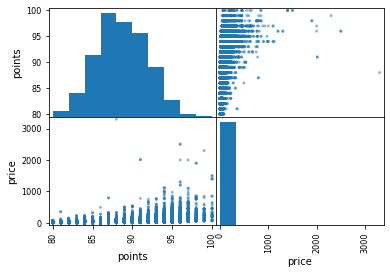

In [4]:
from pandas.plotting import scatter_matrix

attributes = ["points", "price"]
scatter_matrix(wineReviews_all[attributes])

In [5]:
corr_matrix = wineReviews_all.corr()
corr_matrix["points"].sort_values(ascending=True)

Unnamed: 0   -0.063021
price         0.437456
points        1.000000
Name: points, dtype: float64

In [6]:
fill = "nowhere"
wineReviews_all["province"].fillna(fill, inplace=True)
wineReviews_all["region_1"].fillna(fill, inplace=True)

fill = "mystery"
wineReviews_all["variety"].fillna(fill, inplace=True)

wineReviews_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280901 entries, 0 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   280901 non-null  int64  
 1   country      280833 non-null  object 
 2   description  280901 non-null  object 
 3   designation  197701 non-null  object 
 4   points       280901 non-null  int64  
 5   price        258210 non-null  float64
 6   province     280901 non-null  object 
 7   region_1     280901 non-null  object 
 8   region_2     111464 non-null  object 
 9   variety      280901 non-null  object 
 10  winery       280901 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 25.7+ MB


In [7]:
from sklearn.preprocessing import OrdinalEncoder

#Ordinal encoder should be fine for this application since there's not much in the way of similarity between categories.
#Might try a one-hot encoder later.
cat_encoder = OrdinalEncoder()

wine_province = wineReviews_all[["province"]]
wine_region1 = wineReviews_all[["region_1"]]
wine_variety = wineReviews_all[["variety"]]


wine_province_ord = cat_encoder.fit_transform(wine_province)
wine_region1_ord = cat_encoder.fit_transform(wine_region1)
wine_variety_ord = cat_encoder.fit_transform(wine_variety)

wineReviews_all["province"] = wine_province_ord
wineReviews_all["region_1"] = wine_region1_ord
wineReviews_all["variety"] = wine_variety_ord

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001234973C788>,
      dtype=object)

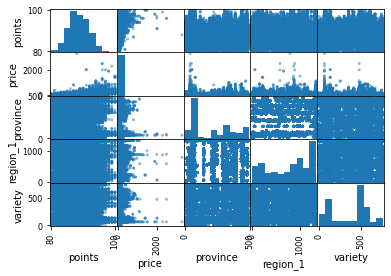

In [9]:
from pandas.plotting import scatter_matrix

#See if there's any notiecable correlations using a scatter matrix
attributes = ["points", "price", "province", "region_1", "variety"]
scatter_matrix(wineReviews_all[attributes])

In [3]:
import numpy as np

#Reset back to normal
wineReviews1 = load_wine_data("winemag-data_first150k.csv")
wineReviews2 = load_wine_data( "winemag-data-130k-v2.csv")

wineReviews2.drop(['taster_twitter_handle', 'title', 'taster_name'],axis = 1,inplace=True)

wineReviews = pd.concat([wineReviews1, wineReviews2], axis = 0)

#Split into training set and test set
def split_train_test(data, test_ratio):
    np.random.seed(42) #To produce the same shuffled indices each time
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(wineReviews, 0.2)
print(len(train_set))
print(len(test_set))

224721
56180


['Merlot' 'Syrah' 'Pinot Noir' 'Bordeaux-style Red Blend' 'Riesling'
 'Chardonnay' 'Cabernet Sauvignon' 'Red Blend' 'Sauvignon Blanc']
['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Sauvignon Blanc', 'Riesling', 'Syrah', 'Merlot']


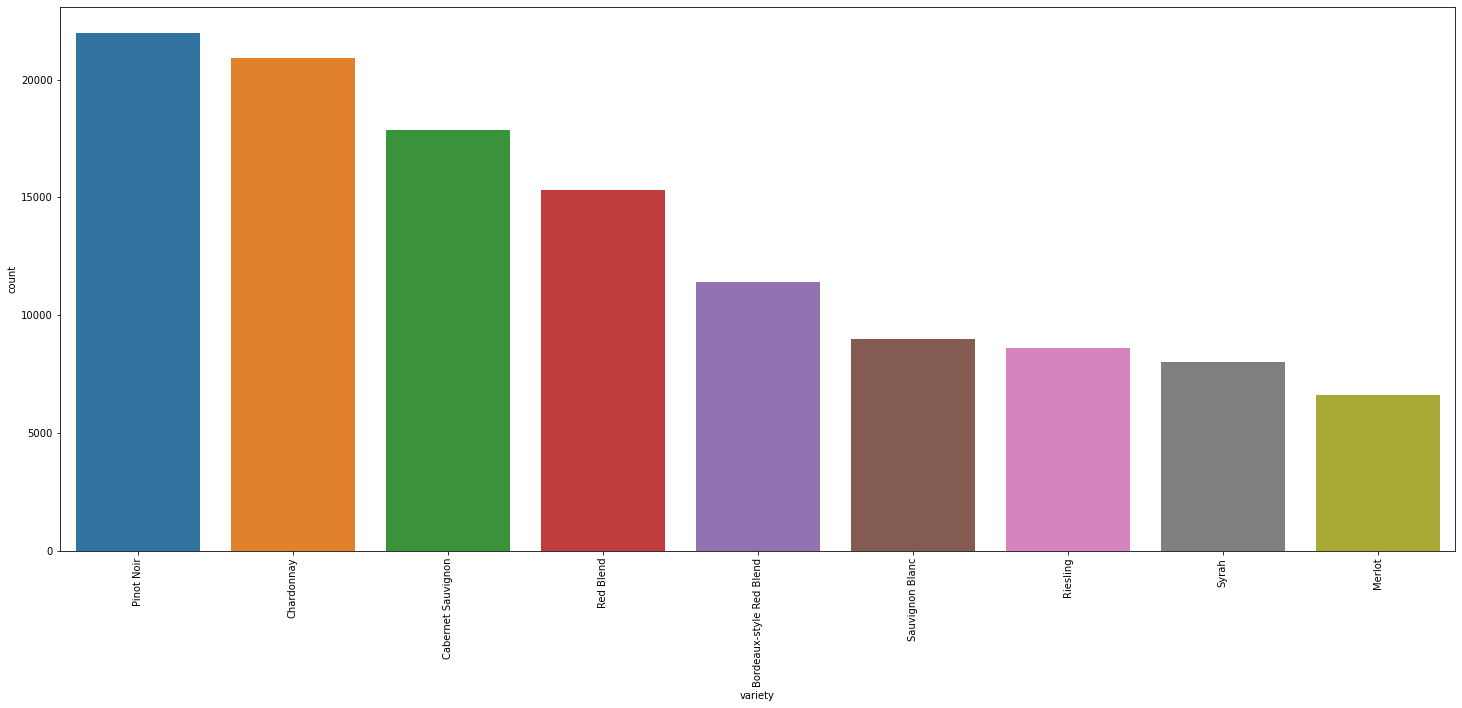

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

#get the wine varieties with more than 4000 reviews
variety_common = train_set.groupby("variety").filter(lambda x: len(x) > 6000)
varieties = variety_common["variety"].value_counts().index.tolist()

print(variety_common['variety'].unique())
print(varieties)

fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_common['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [5]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

train_set = train_set.drop_duplicates('description')
#may want to get rid of variety names, years, and punctuations
punc = ['.', '. .', '. . .', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", '$', '+', '/', '-', '1', '2', 
        '3','4','5','6','7','8','9', 'flavor'] 
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_common['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

word_features = vectorizer.get_feature_names()
word_features[500:525]

['78',
 '784',
 '79',
 '790',
 '795',
 '7g',
 '7th',
 '80',
 '800',
 '800th',
 '80s',
 '80th',
 '81',
 '82',
 '820',
 '828',
 '83',
 '84',
 '843',
 '845',
 '84s',
 '85',
 '850',
 '853',
 '86']

In [6]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
tokenizer = TweetTokenizer()

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [14]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 500)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
word_features2[:50]

C:\Users\Mathias\anaconda3\envs\HOML\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


['10',
 '100',
 '15',
 '20',
 '2010',
 '2012',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 'accent',
 'acid',
 'ad',
 'add',
 'addit',
 'aftertast',
 'age',
 'alcohol',
 'almond',
 'alongsid',
 'alreadi',
 'alway',
 'ampl',
 'anis',
 'anoth',
 'appeal',
 'appel',
 'appl',
 'approach',
 'apricot',
 'aroma',
 'aromat',
 'asian',
 'astring',
 'attract',
 'auster',
 'bacon',
 'bake',
 'balanc',
 'barrel',
 'basic',
 'bean',
 'beauti',
 'beef',
 'befor',
 'begin',
 'berri',
 'best']

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 15, n_init = 5)
kmeans.fit(X2)

KMeans(n_clusters=15, n_init=5)

In [16]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features2[word] for word in centroid))

0 : finish, riesl, citrus, palat, lemon, peach, lime, acid, note, miner
1 : blackberri, currant, dri, tannin, cherri, rich, oak, wine, year, cabernet
2 : blanc, sauvignon, crisp, citrus, grapefruit, green, acid, lime, gooseberri, fruit
3 : berri, aroma, herbal, finish, plum, palat, feel, note, nose, fruit
4 : sampl, barrel, wine, fruit, tannin, ripe, structur, wood, juici, veri
5 : pinot, noir, cherri, cola, silki, raspberri, dri, acid, drink, wine
6 : cabernet, sauvignon, blend, merlot, franc, petit, verdot, wine, syrah, cherri
7 : butter, toast, chardonnay, pineappl, vanilla, oak, rich, acid, pear, fruit
8 : chardonnay, pineappl, oak, acid, tropic, peach, fruit, pear, wine, vanilla
9 : appl, pear, green, finish, palat, wine, aroma, fresh, citrus, lemon
10 : black, cherri, palat, aroma, pepper, tannin, plum, spice, fruit, nose
11 : wine, acid, fruiti, drink, fresh, fruit, ripe, attract, textur, charact
12 : wine, fruit, age, structur, tannin, wood, firm, rich, ripe, year
13 : sweet, c

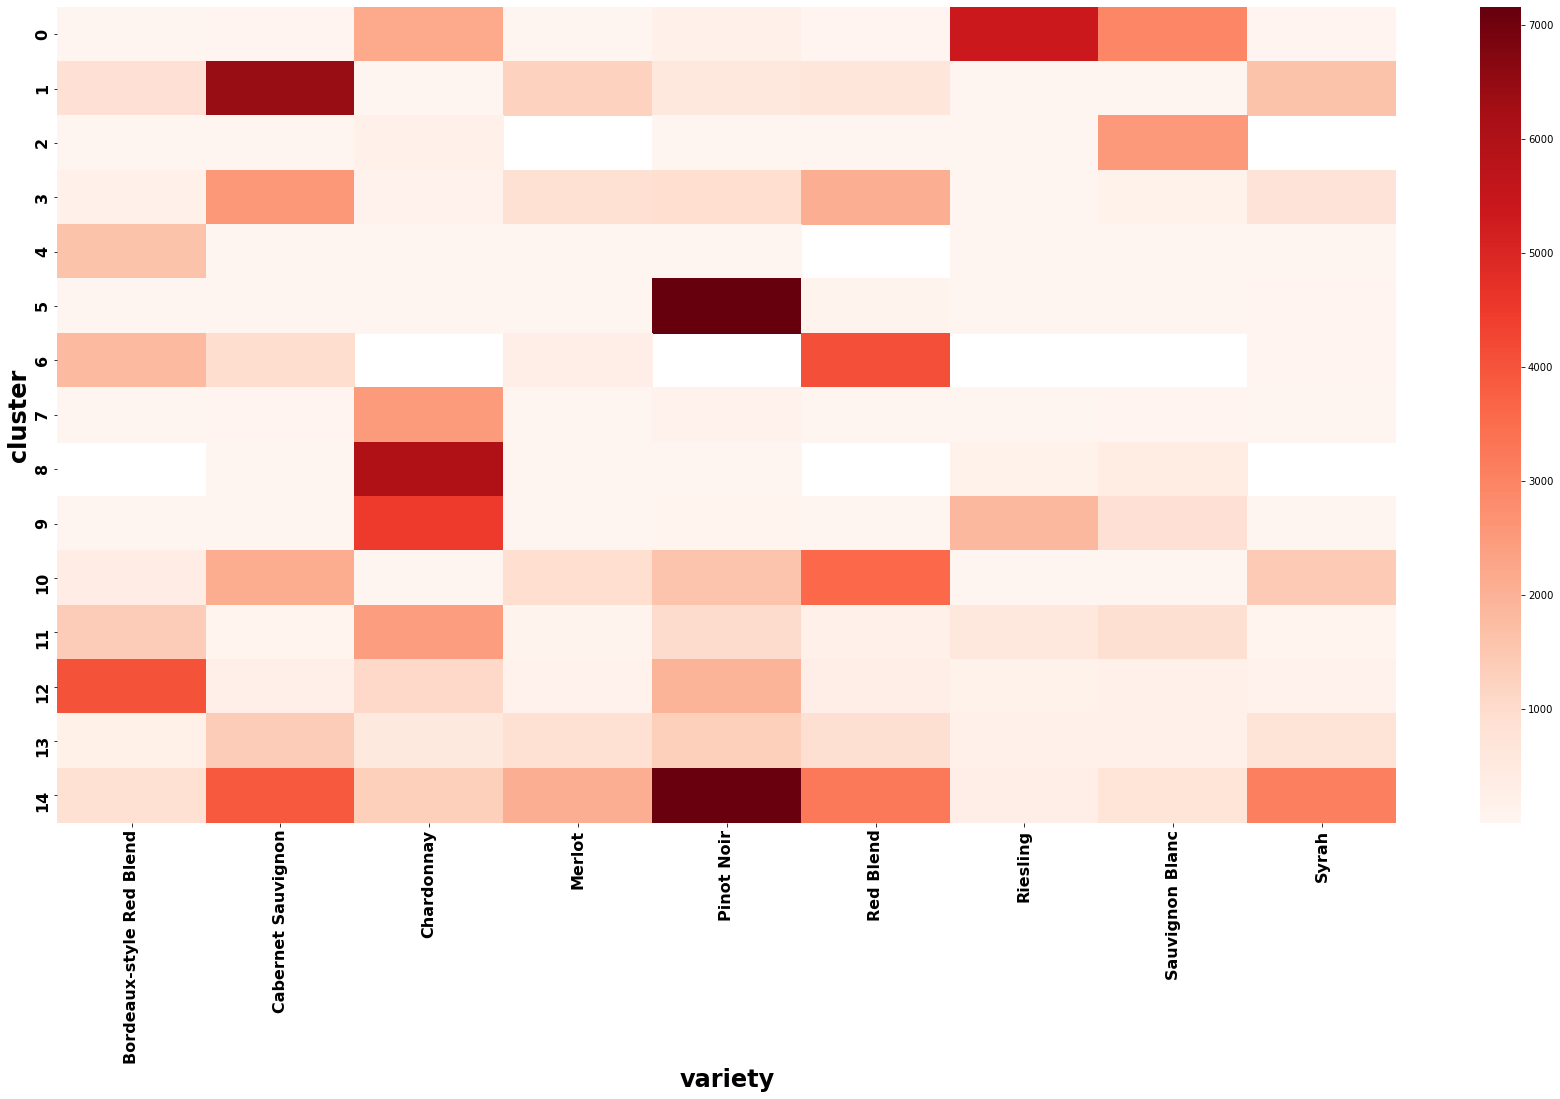

In [17]:
#Create a heat map to see which clusters above correspond to which varieties
variety_common['cluster'] = kmeans.labels_
clusters = variety_common.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
plt.xticks(rotation = 90)
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

In [18]:
#Ok so that's fun, but let's try to find the optimal number of clusters. I tried
#running KMeans to get an elbow graph several times, but it takes a long time so 
#I'm using mini-batch K-Means instead because it's much faster. 
from sklearn.cluster import MiniBatchKMeans
'''
n_clusters: The number of clusters/centroids to form
random_state: Determines random number generation for centroid initialization
n_jobs: Number of threads used for computation, -1 uses all processors
n_init: Number of times algorithm will be run with different centroid seeds
'''
kmeans_per_k = [MiniBatchKMeans(n_clusters = k, random_state=42, n_init = 5).fit(X2) for k in range(1,25)]
intertias = [model.inertia_ for model in kmeans_per_k]


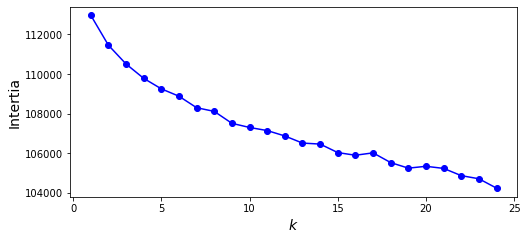

In [19]:
plt.figure(figsize=(8,3.5))
plt.plot(range(1,25), intertias, "bo-")
plt.xlabel("$k$", fontsize = 14)
plt.ylabel("Intertia", fontsize = 14)
plt.show()

In [76]:
#Not particularly insightful, the more clusters there are the less inertia and I don't think it'll dramatically
#decrease with more clusters because grouping words is difficult using K-Means. Try a silhouette score just
#for fun. WARNING THIS TAKES LIKE 3 HOURS TO RUN COMPUTING THESE ON SUCH A LARGE SET IS ROUGH
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X2, model.labels_) for model in kmeans_per_k[1:]]

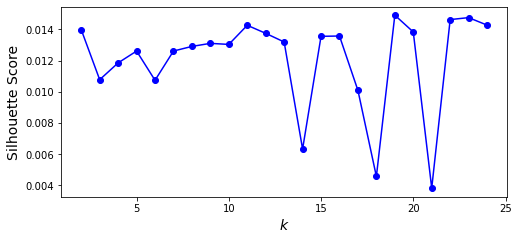

In [77]:
plt.figure(figsize=(8,3.5))
plt.plot(range(2,25), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize = 14)
plt.ylabel("Silhouette Score", fontsize = 14)
plt.show()

In [20]:
#ok so 11, 19, and 23 seem like a good number of clusters (closer to +1 the better) so I'll just go
#with 21 and rerun the K-Means with that. Honestly they all suck the silhouette score is really telling
#me that all of the instances are close to a cluster boundary.

kmeans21 = KMeans(n_clusters = 19, n_init = 5)
kmeans21.fit(X2)

KMeans(n_clusters=19, n_init=5)

In [21]:
#Get the new clusters
common_words2 = kmeans21.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words2):
    print(str(num) + ' : ' + ', '.join(word_features2[word] for word in centroid))

0 : meat, smoke, black, wine, pepper, grill, syrah, pair, red, aroma
1 : cabernet, sauvignon, blend, merlot, franc, petit, verdot, wine, syrah, cherri
2 : berri, aroma, finish, herbal, plum, palat, feel, note, nose, fruit
3 : tast, like, wine, smell, sweet, cherri, fruit, acid, finish, oak
4 : import, wine, finish, fruit, aroma, palat, nose, note, citrus, bit
5 : blanc, sauvignon, crisp, citrus, grapefruit, acid, lime, green, wine, gooseberri
6 : wine, fruit, age, structur, tannin, wood, firm, rich, year, ripe
7 : green, appl, wine, finish, fruit, acid, lime, aroma, crisp, citrus
8 : simpl, sweet, soft, cherri, wine, finish, fruit, raspberri, candi, light
9 : pinot, noir, cherri, cola, silki, raspberri, dri, acid, drink, wine
10 : fruit, wine, cherri, finish, red, tannin, aroma, light, spice, oak
11 : black, cherri, palat, aroma, pepper, tannin, plum, spice, fruit, nose
12 : appl, pear, finish, palat, aroma, lemon, fresh, wine, nose, acid
13 : sampl, barrel, wine, fruit, tannin, ripe, 

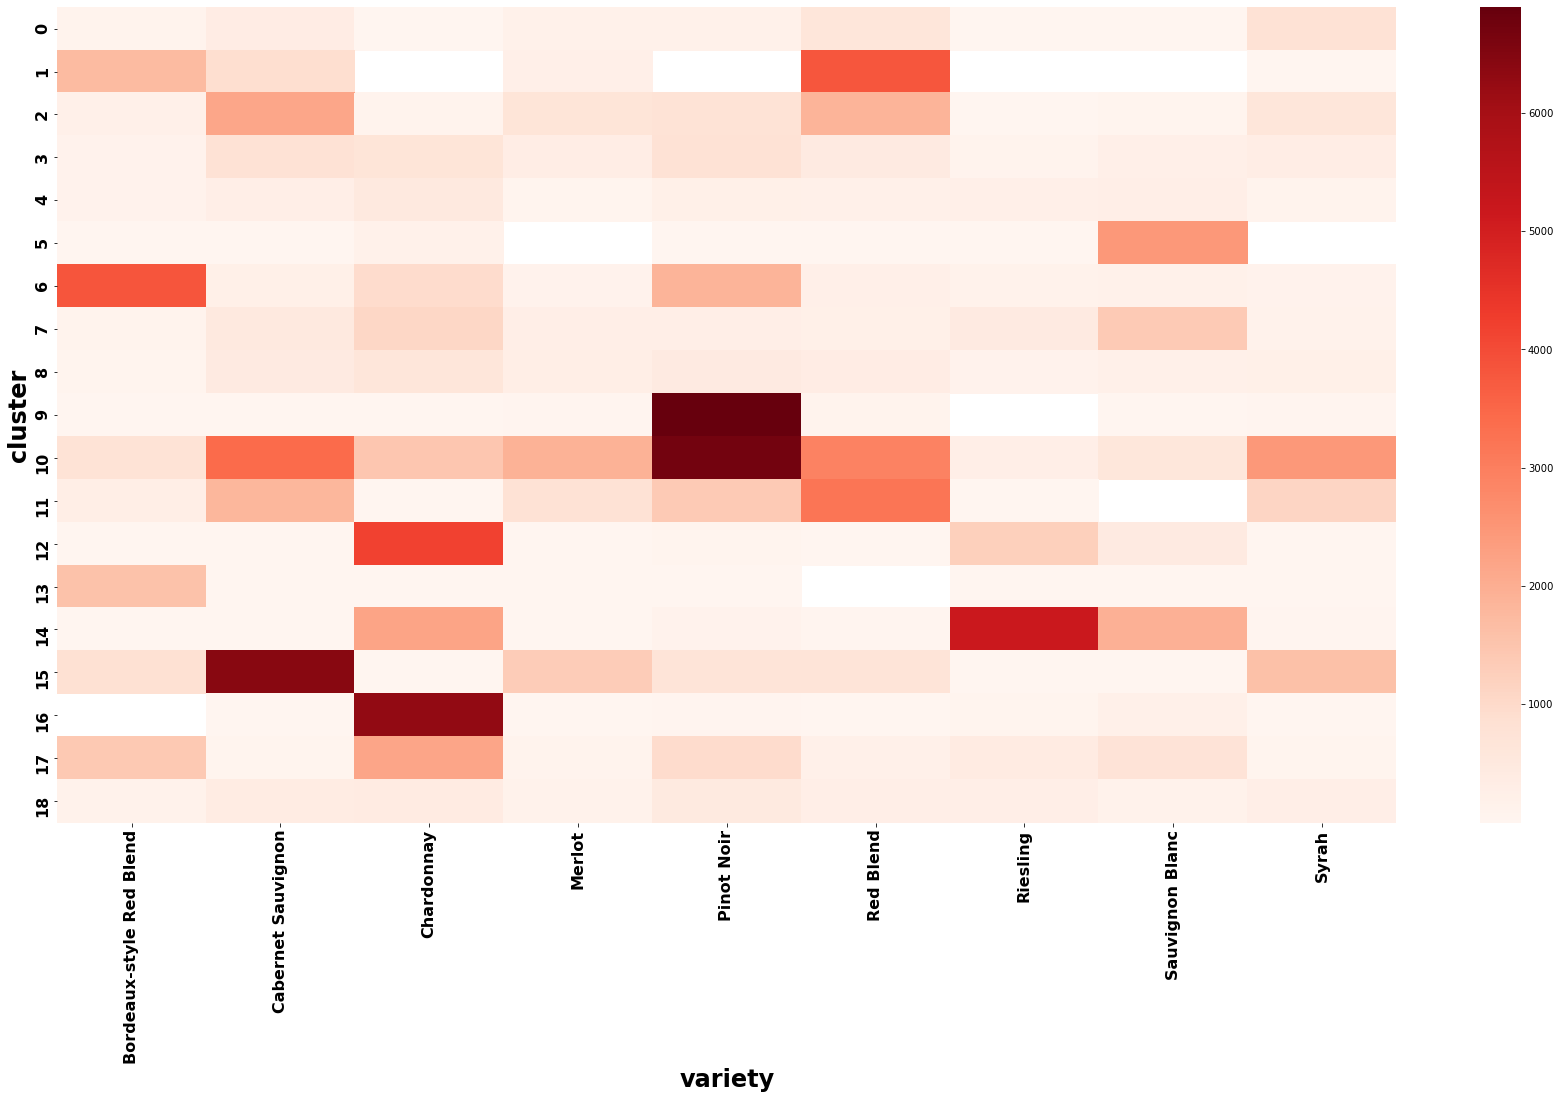

In [22]:
#New heat map for clusters
variety_common['cluster'] = kmeans21.labels_
clusters = variety_common.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
plt.xticks(rotation = 90)
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

In [11]:
#I want a small amount to use Birch on
birch_train, birch_set = split_train_test(train_set, 0.90)

len(birch_train)

variety_common = birch_train.groupby("variety").filter(lambda x: len(x) > 100)

birch_train = birch_train.drop_duplicates('description')
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_common['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

word_features = vectorizer.get_feature_names()
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 500)
X3 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()

C:\Users\Mathias\anaconda3\envs\HOML\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [12]:
X3

<12173x500 sparse matrix of type '<class 'numpy.float64'>'
	with 201798 stored elements in Compressed Sparse Row format>

In [30]:
from sklearn.cluster import Birch

birch = Birch(threshold = 0.97)
birch.fit(X3)
birch.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [26]:
common_words3 = birch.subcluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words3):
    print(str(num) + ' : ' + ', '.join(word_features2[word] for word in centroid))

0 : lack, heavi, mocha, cassi, structur, blackberri, soft, —, extra, express
1 : almond, carri, element, savori, attract, earthi, fruiti, dri, aroma, wine
2 : low, chunki, tough, ferment, skin, cool, befor, wineri, develop, noir
3 : typic, vine, lack, nuanc, mint, bold, import, alongsid, big, cassi
4 : slight, merlot, quick, fair, approach, medium, blueberri, clove, bodi, sauvignon
5 : auster, despit, overal, stone, impress, accent, honey, pineappl, herbal, bit
6 : edg, hit, old, sourc, midpal, includ, beauti, mix, best, great
7 : fig, juic, espresso, combin, anis, mocha, —, complex, offer, blackberri
8 : aroma, finish, palat, plum, berri, cherri, black, note, fruit, nose
9 : extrem, drinkabl, fulli, cocoa, sugar, suggest, merlot, eleg, cabernet, blackberri
10 : sour, grapefruit, —, feel, entir, espresso, estat, everyday, excel, exot
11 : butteri, modest, load, turn, oaki, toasti, bake, pear, peach, vanilla
12 : grip, intrigu, certain, rustic, appeal, depth, meat, wild, smoke, make
13 

<12173x500 sparse matrix of type '<class 'numpy.float64'>'
	with 201798 stored elements in Compressed Sparse Row format>